<a href="https://colab.research.google.com/github/NataliaKolesnik/Car_Price_prediction_part2/blob/master/4_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [39]:
!pip install -U lightautoml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
path_data = '/content/drive/MyDrive/SF_project_8/data/'

##Библиотеки

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [42]:
pd.set_option('display.float_format', '{:.2f}'.format)

SEED = 42
np.random.seed(SEED)


## Загрузка и подготовка данных для обучения

In [43]:
df_train = pd.read_csv(path_data+'train_for_ML.csv')
df_test = pd.read_csv(path_data+'test_for_ML.csv')

In [44]:
# Списки с признаками

categorical_features = ['bodyType', 'brand', 'model_info', 'brand_model', 'color', 
                          'fuelType_littel', 'vehicleTransmission', 'Привод' ]

numerical_features = ['engineDisplacement', 'enginePower', 'enginePower_log', 'mileage', 
                      'age_avto', 'mileage_/_age_avto', 'Владельцы', 
                        'numberOfDoors', 'xDrive', 'ПТС_10']

target = 'price'
target_log = 'price_log'

In [45]:
# Соберем датасеты

X = df_train[categorical_features + numerical_features]

X_test = df_test[categorical_features + numerical_features]

Y = df_train[target]
Y_log = df_train[target_log]

In [46]:
# Стандартизируем числовые данные

scaler = MinMaxScaler()

X[numerical_features] = scaler.fit_transform(X[numerical_features])
X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [47]:
X.describe()

,engineDisplacement,enginePower,enginePower_log,mileage,age_avto,mileage_/_age_avto,Владельцы,numberOfDoors,xDrive,ПТС_10
count,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00
mean,0.42,0.32,0.54,0.12,0.21,0.17,0.55,0.76,0.11,0.89
std,0.16,0.19,0.18,0.08,0.13,0.09,0.42,0.29,0.32,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.19,0.42,0.06,0.11,0.12,0.00,0.67,0.00,1.00
50%,0.42,0.28,0.53,0.11,0.18,0.17,0.50,0.67,0.00,1.00
75%,0.45,0.41,0.66,0.17,0.29,0.22,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [48]:
X_test.describe()

,engineDisplacement,enginePower,enginePower_log,mileage,age_avto,mileage_/_age_avto,Владельцы,numberOfDoors,xDrive,ПТС_10
count,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00
mean,0.42,0.26,0.44,0.12,0.21,0.23,0.55,0.75,0.11,0.90
std,0.16,0.18,0.19,0.08,0.14,0.12,0.41,0.30,0.31,0.30
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.14,0.31,0.06,0.11,0.15,0.00,0.67,0.00,1.00
50%,0.41,0.22,0.43,0.11,0.18,0.22,0.50,0.67,0.00,1.00
75%,0.45,0.34,0.57,0.17,0.29,0.29,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [12]:
# Закодируем категориальные переменные (так как в тестовой выборки есть такие модели авто, которые отсутсвуют в тренировочной, то для кодирования датасеты придется объединить) 

X['sample'] = 1
X_test['sample'] = 0

X_join = pd.concat([X, X_test])

#X_join = pd.get_dummies(X_join, columns=categorical_features)

X = X_join[X_join['sample'] == 1].drop(['sample'], axis=1)
X_test = X_join[X_join['sample'] == 0].drop(['sample'], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [49]:
# Разбиваем на обучающую и валидационную выборки

X_train = pd.concat([Y, X], axis=1)
X_train_log = pd.concat([Y_log, X], axis=1)

# X_train, X_valid = train_test_split(X, test_size=0.2, random_state=SEED, shuffle=True)
# X_train_log, X_valid_log = train_test_split(X_log, test_size=0.2, random_state=SEED, shuffle=True)

## Обучение модели

In [50]:
# определяем задачу

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

task = Task('reg', loss='mape', metric='mae')

In [51]:
# определяем роли

roles = {
    'target' : 'price_log',
    
}

In [52]:
# создаем модель
automl_1 = TabularAutoML(
    task=task,
    timeout=60*60,
    general_params = {
        'use_algos': [['linear_l2', 'lgb_tuned', 'cb_tuned'], ['linear_l2'] ]
        },
    reader_params={
        'cv': 10,
        'random_state': SEED,
        'verbose': 1
    }
)

In [53]:
oof_pred_1 = automl_1.fit_predict(X_train_log, roles=roles, verbose=1)

[15:21:38] Stdout logging level is INFO.
[15:21:38] Task: reg

[15:21:38] Start automl preset with listed constraints:
[15:21:38] - time: 3600.00 seconds
[15:21:38] - CPU: 4 cores
[15:21:38] - memory: 16 GB

[15:21:38] Train data shape: (6682, 19)

[15:21:41] Layer 1 train process start. Time left 3597.16 secs
[15:21:41] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:21:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.17655671598963504
[15:21:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:21:47] Time left 3590.86 secs

[15:21:56] Selector_LightGBM fitting and predicting completed
[15:21:57] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-ce660a6b-2dc0-4fa3-b374-fd0c67dd8d8a
INFO:optuna.study.study:Trial 0 finished with value: -0.11877523755203266 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.11877523755203266.
INFO:optuna.study.study:Trial 1 finished with value: -0.11692344971977782 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -0.11692344971977782.
INFO:optuna.study.study:Trial 2 finished with value: -0.11831056832233726 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fra

[15:27:22] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM completed
[15:27:22] Start fitting Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM ...
[15:29:35] Fitting Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM finished. score = -0.12493997233307728
[15:29:35] Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM fitting and predicting completed
[15:29:35] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c380e54a-c489-440f-a7e5-11576d797982
INFO:optuna.study.study:Trial 0 finished with value: -0.12464568526833938 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.12464568526833938.
INFO:optuna.study.study:Trial 1 finished with value: -0.1274187115601881 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.12464568526833938.
INFO:optuna.study.study:Trial 2 finished with value: -0.12895929968280317 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.12464568526833938.
INFO:optuna.study.study:Trial 3 finished with value: -0.1274187115601881 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_da

[15:34:38] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost completed
[15:34:38] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost ...
[15:35:47] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost finished. score = -0.12530105459647048
[15:35:47] Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost fitting and predicting completed
[15:35:47] Time left 2750.68 secs

[15:35:47] Layer 1 training completed.

[15:35:47] Layer 2 train process start. Time left 2750.65 secs
[15:35:48] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[15:35:52] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.12272100277340206
[15:35:52] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:35:52] Time left 2745.72 secs

[15:35:52] Layer 2 training completed.

[15:35:52] Automl preset training completed in 854.28 seconds

[15:35:52] Model description:
Models on level 0:
	 10 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 10 averaged models Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM
	 10 averaged models Lvl_0_Pipe_1_M

In [54]:
# Структура модели
print(automl_1.create_model_str_desc())

Models on level 0:
	 10 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 10 averaged models Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM
	 10 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (10 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 


In [55]:
oof_pred_exp = np.exp(oof_pred_1.data[:, 0])

mean_absolute_percentage_error(np.exp(X_train_log['price_log']), oof_pred_exp)

0.11907802617398609

In [28]:
oof_pred_exp = np.exp(oof_pred_1.data[:, 0])

mean_absolute_percentage_error(np.exp(X_train_log['price_log']), oof_pred_exp)

0.14104262448883456

### Важность признаков

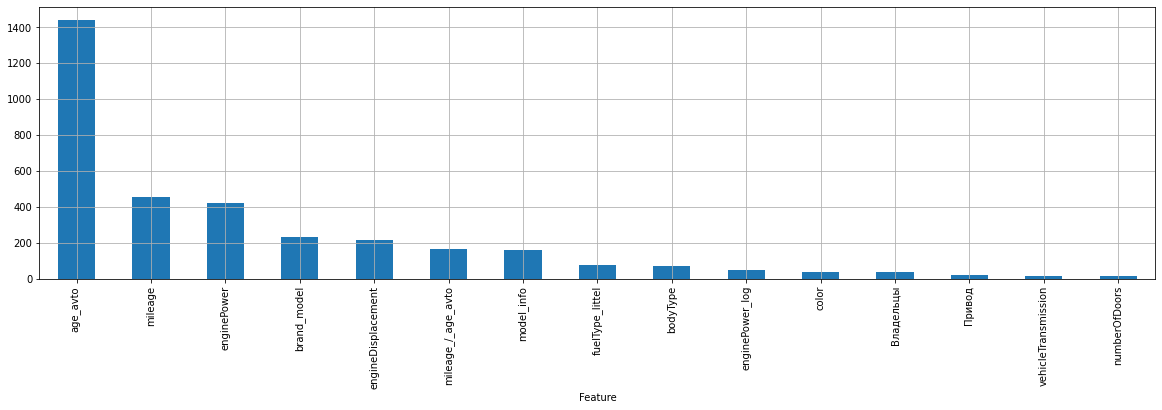

In [56]:
fast_fi_1 = automl_1.get_feature_scores('fast')
fast_fi_1[:15].set_index('Feature')['Importance'].plot.bar(figsize=(20, 5), grid=True)

In [58]:
# создаем модель
automl_2 = TabularUtilizedAutoML(
    task=task,
    timeout=60*60,
    general_params = {
        'use_algos': [['linear_l2', 'lgb', 'cb', 'lgb_tuned', 'cb_tuned'], ['linear_l2', 'lgb', 'cb'], ]
        },
    reader_params={
        'cv': 10,
        'random_state': SEED,
        'verbose': 1
    }
)

In [59]:
oof_pred_2 = automl_2.fit_predict(X_train_log, roles=roles, verbose=1)

[15:39:43] Start automl utilizator with listed constraints:
[15:39:43] - time: 3600.00 seconds
[15:39:43] - CPU: 4 cores
[15:39:43] - memory: 16 GB

[15:39:43] If one preset completes earlier, next preset configuration will be started

[15:39:43] ==================================================
[15:39:43] Start 0 automl preset configuration:
[15:39:43] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[15:39:43] Stdout logging level is INFO.
[15:39:43] Task: reg

[15:39:43] Start automl preset with listed constraints:
[15:39:43] - time: 3599.99 seconds
[15:39:43] - CPU: 4 cores
[15:39:43] - memory: 16 GB

[15:39:43] Train data shape: (6682, 19)

[15:39:45] Layer 1 train process start. Time left 3597.24 secs
[15:39:46] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:39:52] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.17655671598963504
[15:39:52] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predict

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-56535977-ef5e-4ab1-8f98-b71d1aa0992d
INFO:optuna.study.study:Trial 0 finished with value: -0.11877523755203266 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.11877523755203266.
INFO:optuna.study.study:Trial 1 finished with value: -0.11692344971977782 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -0.11692344971977782.
INFO:optuna.study.study:Trial 2 finished with value: -0.11831056832233726 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fra

[15:45:34] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:45:34] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[15:47:48] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.12493997233307728
[15:47:48] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:47:48] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[15:48:27] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.12784078305241442
[15:48:27] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:48:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-02d398e0-9878-46aa-a242-1f5ff679b015
INFO:optuna.study.study:Trial 0 finished with value: -0.12464568526833938 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.12464568526833938.
INFO:optuna.study.study:Trial 1 finished with value: -0.1274187115601881 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.12464568526833938.
INFO:optuna.study.study:Trial 2 finished with value: -0.12895929968280317 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.12464568526833938.
INFO:optuna.study.study:Trial 3 finished with value: -0.1274187115601881 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_da

[15:53:29] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[15:53:29] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[15:54:38] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.12530105459647048
[15:54:38] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[15:54:38] Time left 2704.55 secs

[15:54:38] Layer 1 training completed.

[15:54:38] Layer 2 train process start. Time left 2704.53 secs
[15:54:39] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[15:54:43] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.123263267689931
[15:54:43] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:54:43] Time left 2699.66 secs

[15:54:44] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
[15:55:29] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.12550216476732257
[15:55:29] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:55:29] Start fitting Lvl_1_Pipe_1_Mod_1_CatBoost ...
[15:55:45] Fitting Lv

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-cb4f7c7f-defc-42c5-8099-47c6a9bd3030
INFO:optuna.study.study:Trial 0 finished with value: -0.11044918578312529 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.11044918578312529.


[15:59:15] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:59:15] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[16:01:46] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.12689731130116827
[16:01:46] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[16:01:46] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[16:02:27] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.12598328574884704
[16:02:27] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:02:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-e89fe726-a4a6-4783-abe0-e2065658a144
INFO:optuna.study.study:Trial 0 finished with value: -0.11944907550797393 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.11944907550797393.
INFO:optuna.study.study:Trial 1 finished with value: -0.12368028328167577 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.11944907550797393.
INFO:optuna.study.study:Trial 2 finished with value: -0.12428662710593169 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.11944907550797393.
INFO:optuna.study.study:Trial 3 finished with value: -0.12368028328167577 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_

[16:07:28] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[16:07:28] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[16:08:21] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.12501167770993377
[16:08:21] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[16:08:21] Time left 1881.22 secs

[16:08:21] Layer 1 training completed.

[16:08:21] Layer 2 train process start. Time left 1881.20 secs
[16:08:22] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[16:08:26] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.12350546698719497
[16:08:26] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:08:26] Time left 1876.66 secs

[16:08:27] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
[16:10:54] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.12855621278680618
[16:10:54] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[16:10:54] Start fitting Lvl_1_Pipe_1_Mod_1_CatBoost ...
[16:11:34] Fitting 

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-206c2b2a-dbc0-4d61-9ebf-c57cf65ad1e9
INFO:optuna.study.study:Trial 0 finished with value: -0.12189228483767675 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.12189228483767675.


[16:14:08] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:14:08] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[16:15:30] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.12815860809747281
[16:15:30] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[16:15:30] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[16:16:06] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.12968061372148834
[16:16:06] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:16:06] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-e9a3982a-8ed6-43e7-b25c-c3771d315556
INFO:optuna.study.study:Trial 0 finished with value: -0.12837184466970153 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.12837184466970153.
INFO:optuna.study.study:Trial 1 finished with value: -0.1289239677259631 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.12837184466970153.
INFO:optuna.study.study:Trial 2 finished with value: -0.13134836978714795 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 13}. Best is trial 0 with value: -0.12837184466970153.
INFO:optuna.study.study:Trial 3 finished with value: -0.1273359268959566 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 20}. Best is trial 3 with value: -0.1273359268959566.
INFO:optun

[16:21:10] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[16:21:10] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[16:22:11] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.1273251992100352
[16:22:11] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[16:22:11] Time left 1052.16 secs

[16:22:11] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[16:22:11] Layer 1 training completed.

[16:22:11] Blending: optimization starts with equal weights and score -0.12995506099190066
[16:22:11] Blending: iteration 0: score = -0.12506591846326673, weights = [0.         0.12477759 0.37063015 0.12479801 0.37979427]
[16:22:11] Blending: iteration 1: score = -0.12502591116799058, weights = [0.         0.09175441 0.402136   0.06323005 0.44287953]
[16:22:11] Blending: iteration 2: score = -0.1250247920695284, weights = [0.         0.08551282 0.40887332 0.06232988 0.44328395]
[16:22:11] Blending: iteration 3: s

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-25dd7458-1816-44c7-889a-8e7bbf955178
INFO:optuna.study.study:Trial 0 finished with value: -0.1356512148393883 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.1356512148393883.


[16:23:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[16:23:57] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[16:25:28] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.12768860408658397
[16:25:28] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[16:25:28] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[16:26:01] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.12917144295677502
[16:26:01] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[16:26:01] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-5fb44c68-117b-4174-96ee-1bf300ea2f8c
INFO:optuna.study.study:Trial 0 finished with value: -0.13485268065032915 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.13485268065032915.
INFO:optuna.study.study:Trial 1 finished with value: -0.13982236698505676 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.13485268065032915.
INFO:optuna.study.study:Trial 2 finished with value: -0.13856496545540503 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.13485268065032915.
INFO:optuna.study.study:Trial 3 finished with value: -0.13982236698505676 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_

[16:31:02] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[16:31:02] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[16:31:44] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.12735897373313892
[16:31:44] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[16:31:44] Time left 478.82 secs

[16:31:44] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[16:31:44] Layer 1 training completed.

[16:31:44] Blending: optimization starts with equal weights and score -0.12851343683445335
[16:31:44] Blending: iteration 0: score = -0.12435109277714411, weights = [0.         0.09016765 0.42232347 0.19190775 0.2956012 ]
[16:31:44] Blending: iteration 1: score = -0.12434291613150537, weights = [0.         0.         0.4738869  0.19187188 0.33424118]
[16:31:44] Blending: iteration 2: score = -0.12434171624199804, weights = [0.         0.05597175 0.45006865 0.17158717 0.32237244]
[16:31:44] Blending: iteration 3: 

In [ ]:
# Структура модели
print(automl_2.create_model_str_desc())


Final prediction for new objects = 
	0.23194 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 10 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 10 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 10 averaged models Lvl_0_Pipe_1_Mod_1_CatBoost

		Final prediction for new objects (level 1) = 
			 0.69292 * (10 averaged models Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM) +
			 0.30708 * (10 averaged models Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost) 


	+ 0.23287 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 10 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 10 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 10 averaged models Lvl_0_Pipe_1_Mod_1_CatBoost

		Final prediction for new objects (level 1) = 
			 0.37041 * (10 averaged models Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM) +
			 0.62959 * (10 averaged models 

In [60]:
oof_pred_exp_2 = np.exp(oof_pred_2.data[:, 0])

mean_absolute_percentage_error(np.exp(X_train_log['price_log']), oof_pred_exp_2)

0.11766588655896024

In [ ]:
oof_pred_exp_2 = np.exp(oof_pred_2.data[:, 0])

mean_absolute_percentage_error(np.exp(X_train_log['price_log']), oof_pred_exp_2)

0.11478351257796071

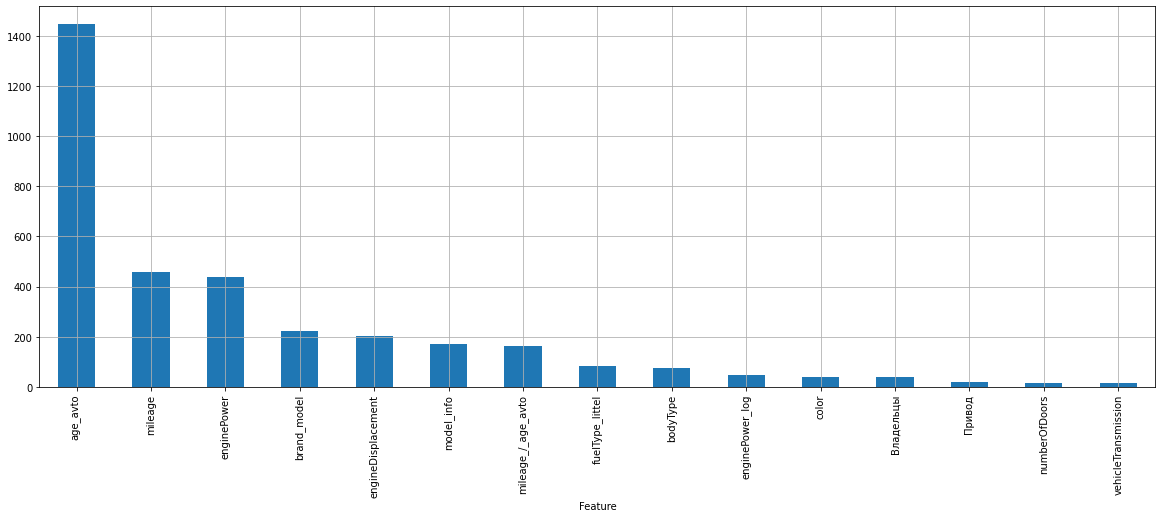

In [61]:
fast_fi_2 = automl_2.get_feature_scores('fast')
fast_fi_2[:15].set_index('Feature')['Importance'].plot.bar(figsize=(20, 7), grid=True)

## Предсказание

In [62]:
# предсказываем результат 
y_test_predict = automl_2.predict(X_test)

In [63]:
y_test_predict.data[:,0]

array([13.277322, 14.762826, 13.398691, ..., 14.20237 , 13.875712,
       13.940663], dtype=float32)

In [64]:
y_test_predict = np.exp(y_test_predict.data[:,0])

In [65]:
submission = pd.read_csv(path_data+'sample_submission.csv')
submission['price'] = y_test_predict
submission.to_csv(path_data+'sample_submission_AutoML.csv', index=False)

In [66]:
submission

,sell_id,price
0,1099427284,583804.75
1,1096405886,2578777.25
2,1100195294,659140.00
3,1099827282,470596.38
4,1100076198,2473368.00
...,...,...
1666,1099414488,937215.56
1667,1099277058,2241442.25
1668,1098773964,1472349.12
1669,1098835932,1062051.00


In [ ]:
submission

,sell_id,price
0,1099427284,589983.81
1,1096405886,2680391.75
2,1100195294,686300.38
3,1099827282,521176.03
4,1100076198,2579869.75
...,...,...
1666,1099414488,964937.38
1667,1099277058,2385286.25
1668,1098773964,1452259.38
1669,1098835932,1035648.31


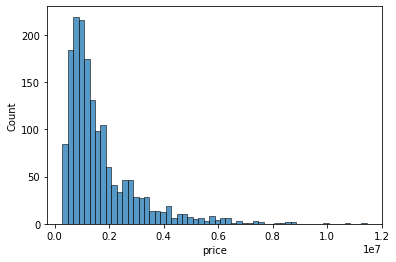

In [ ]:
sns.histplot(submission['price'])